# Load & Plot Metrica data

- Requires Python 3.4 or higher (for pathlib)



- Drawing football pitch code adapted from here: https://stackoverflow.com/questions/54553656/how-to-overlay-seaborn-heatmap-on-matplotlib-figure

- Download metrica-sports player tracking data & update hard-coded paths in the code: https://github.com/metrica-sports/sample-data



Alina Bialkowski | Thu 29 October 2020

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as plt_p
from pathlib import Path
from scipy.stats import kde
import seaborn as sns
import pathlib
from scipy import stats # for Gaussian KDE
from matplotlib.patches import Ellipse
import matplotlib.transforms as transforms

import scipy # for Hungarian linear assignment

In [2]:
# Define the colours for each player here (currently default)
my_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def draw_pitch(ax, width=120, height=80):
    # size of the pitch is width, height
    #Create figure

    #Pitch Outline & Centre Line
    ax.plot([0,0],[0,height], color="black")
    ax.plot([0,width],[height,height], color="black")
    ax.plot([width,width],[height,0], color="black")
    ax.plot([width,0],[0,0], color="black")
    ax.plot([width/2,width/2],[0,height], color="black")

    #Left Penalty Area
    ax.plot([width*0.12,width*0.12],[height*0.72,height*0.28],color="black")
    ax.plot([0,width*0.12],[height*0.72,height*0.72],color="black")
    ax.plot([0,width*0.12],[height*0.28,height*0.28],color="black")

    #Right Penalty Area
    ax.plot([width,width*0.88],[height*0.72,height*0.72],color="black")
    ax.plot([width*0.88,width*0.88],[height*0.72,height*0.28],color="black")
    ax.plot([width, width*0.88],[height*0.28,height*0.28],color="black")

    #Left 6-yard Box
    ax.plot([0,width*0.04],[height*0.6,height*0.6],color="black")
    ax.plot([width*0.04,width*0.04],[height*0.6,height*0.4],color="black")
    ax.plot([0,width*0.04],[height*0.4,height*0.4],color="black")

    #Right 6-yard Box
    ax.plot([width,width*0.96],[height*0.6,height*0.6],color="black")
    ax.plot([width*0.96,width*0.96],[height*0.6,height*0.4],color="black")
    ax.plot([width,width*0.96],[height*0.4,height*0.4],color="black")

    #Prepare Circles
    centreCircle = plt.Circle((width/2,height/2),8.1/120*width,color="black",fill=False)
    centreSpot = plt.Circle((width/2,height/2),0.71/120*width,color="black")
    leftPenSpot = plt.Circle((9.7/120*width,height/2),0.71/120*width,color="black")
    rightPenSpot = plt.Circle((110.3/120*width,height/2),0.71/120*width,color="black")

    #Draw Circles
    ax.add_patch(centreCircle)
    ax.add_patch(centreSpot)
    ax.add_patch(leftPenSpot)
    ax.add_patch(rightPenSpot)

    #Prepare Arcs
    # arguments for arc
    # x, y coordinate of centerpoint of arc
    # width, height as arc might not be circle, but oval
    # angle: degree of rotation of the shape, anti-clockwise
    # theta1, theta2, start and end location of arc in degree
    leftArc = plt_p.Arc((9.7/120*width,height/2),height=16.2/120*width,width=16.2/120*width,angle=0,theta1=310,theta2=50,color="black")
    rightArc = plt_p.Arc((110.3/120*width,height/2),height=16.2/120*width,width=16.2/120*width,angle=0,theta1=130,theta2=230,color="black")

    #Draw Arcs
    ax.add_patch(leftArc)
    ax.add_patch(rightArc)

In [3]:
def confidence_ellipse(x, y, ax, n_std=1.0, facecolor='none', **kwargs):
    """
    Create a plot of the covariance confidence ellipse of `x` and `y`
    From: https://matplotlib.org/3.1.1/gallery/statistics/confidence_ellipse.html#sphx-glr-gallery-statistics-confidence-ellipse-py

    Parameters
    ----------
    x, y : array_like, shape (n, )
        Input data.

    ax : matplotlib.axes.Axes
        The axes object to draw the ellipse into.

    n_std : float
        The number of standard deviations to determine the ellipse's radiuses.

    Returns
    -------
    matplotlib.patches.Ellipse

    Other parameters
    ----------------
    kwargs : `~matplotlib.patches.Patch` properties
    """
    if x.size != y.size:
        raise ValueError("x and y must be the same size")

    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    ell_radius_x = np.sqrt(1 + pearson)
    ell_radius_y = np.sqrt(1 - pearson)
    ellipse = Ellipse((0, 0),
        width=ell_radius_x * 2,
        height=ell_radius_y * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    scale_x = np.sqrt(cov[0, 0]) * n_std
    mean_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    scale_y = np.sqrt(cov[1, 1]) * n_std
    mean_y = np.mean(y)

    transf = transforms.Affine2D() \
        .rotate_deg(45) \
        .scale(scale_x, scale_y) \
        .translate(mean_x, mean_y)

    ellipse.set_transform(transf + ax.transData)
    return ax.add_patch(ellipse)

In [4]:
# Load tracking & events data
base_path = pathlib.Path('/Users/alina/Data/Soccer/metrica-sample-data-master/data/Sample_Game_1')

fn = base_path / 'Sample_Game_1_RawEventsData.csv'
df_events = pd.read_csv(fn)

fn_a = base_path / 'Sample_Game_1_RawTrackingData_Away_Team.csv'
df_tracks_a = pd.read_csv(fn_a, skiprows=2)

fn_h = base_path / 'Sample_Game_1_RawTrackingData_Home_Team.csv'
df_tracks_h = pd.read_csv(fn_h, skiprows=2)

In [5]:
# Copy tracking data from dataframe to numpy arrays
# Away team, first half
tracks_a_G1 = df_tracks_a[df_tracks_a['Period'] == 1].iloc[:, 3:].to_numpy() #columns [3:] is for players + ball
# Home team, first half
tracks_h_G1 = df_tracks_h[df_tracks_h['Period'] == 1].iloc[:, 3:].to_numpy() #columns [3:] is for players + ball

# Away team, second half
tracks_a_G2 = df_tracks_a[df_tracks_a['Period'] == 2].iloc[:, 3:].to_numpy() #columns [3:] is for players + ball
# Home team, second half
tracks_h_G2 = df_tracks_h[df_tracks_h['Period'] == 2].iloc[:, 3:].to_numpy() #columns [3:] is for players + ball

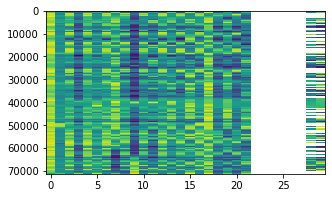

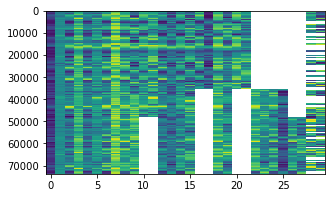

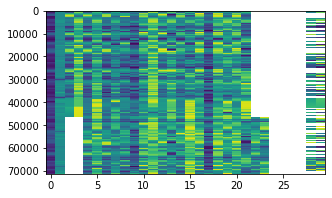

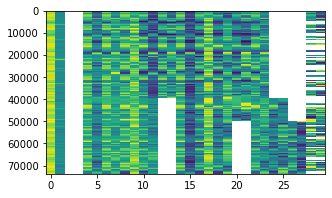

In [6]:
# Figure out which players are 'nan' by plotting using imshow
# Note: order of data is: Player1 (x,y), Player 2 (x,y), ... Ball (x,y)
# Also allows to see when players are substituted
# TODO: figure out which are substituted and make it so that it is just 11 players, and remove nans

fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(tracks_a_G1, interpolation='nearest', aspect='auto')

fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(tracks_a_G2, interpolation='nearest', aspect='auto')

fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(tracks_h_G1, interpolation='nearest', aspect='auto')

fig,ax = plt.subplots(figsize=(5,3))
ax.imshow(tracks_h_G2, interpolation='nearest', aspect='auto')

In [7]:
# Do remaining analysis just on the away team as there are no player subs

# Reshape into a matrix organised into timeIdx*playerIdx*(x,y)
# Also, remove goalie [which was the first player]
tracks_A1 = tracks_a_G1[:,2:22].reshape((len(tracks_a_G1),10,2))

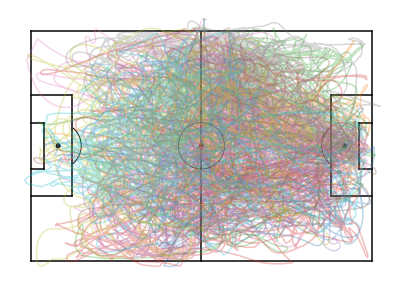

In [8]:
# Plot the tracks
fig = plt.figure()
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1);
draw_pitch(ax)
plt.axis('off')

for playerIdx in range(tracks_A1.shape[1]):
    ax.plot(tracks_A1[:,playerIdx,0]*120, tracks_A1[:,playerIdx,1]*80, alpha=0.3)
    

In [9]:
# Compute tracks with team centroid removed **IGNORE GOALIE
#centroid_everyFrame = np.mean(tracks_A1, axis=1) #(71268, 2)
#tracks_A1_meanNorm = tracks_A1 - centroid_everyFrame

# Normalise
tracks_A1_meanNorm = tracks_A1 - tracks_A1[:,:,:].mean(axis=1, keepdims=True)

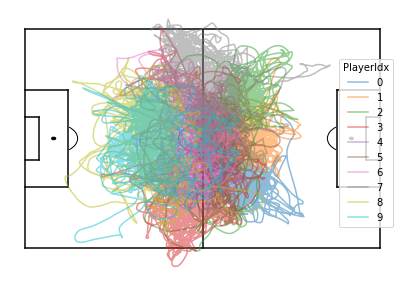

In [10]:
# Plot mean normalised tracks
fig = plt.figure()
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)
draw_pitch(ax, width=1, height=1)
plt.axis('off')

for playerIdx in range(tracks_A1_meanNorm.shape[1]):
    ax.plot(tracks_A1_meanNorm[:,playerIdx,0]+0.5, tracks_A1_meanNorm[:,playerIdx,1]+0.5, alpha=0.5, label=playerIdx)

ax.legend(loc='center right', title="PlayerIdx");

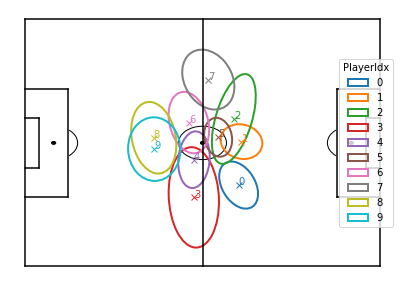

In [11]:
# Draw player distributions
playerMus = np.mean(tracks_A1_meanNorm, axis=0)

fig = plt.figure()
fig.set_size_inches(7, 5)
ax = fig.add_subplot(1,1,1)
draw_pitch(ax, width=1, height=1)
plt.axis('off')

for playerIdx in range(tracks_A1_meanNorm.shape[1]):
    #ax.plot(tracks_A1_meanNorm[:,playerIdx,0]+0.5, tracks_A1_meanNorm[:,playerIdx,1]+0.5, alpha=0.5, label=playerIdx)
    confidence_ellipse(tracks_A1_meanNorm[:,playerIdx,0]+0.5, tracks_A1_meanNorm[:,playerIdx,1]+0.5, ax, n_std=1.0, edgecolor=my_colors[playerIdx], lw=2.0, label=playerIdx)

    
    ax.plot(playerMus[playerIdx, 0]+0.5, playerMus[playerIdx, 1]+0.5, c=my_colors[playerIdx], marker='x')
    ax.annotate(playerIdx, (playerMus[playerIdx, 0]+0.5, playerMus[playerIdx, 1]+0.5), c=my_colors[playerIdx]) # text labels
    
    
ax.legend(loc='center right', title="PlayerIdx");

In [12]:
# Role assignment (simple approach, based on mean)
from scipy.optimize import linear_sum_assignment

tracks_role = np.copy(tracks_A1_meanNorm)
# Set the reference formation; Here it is simply set to the MEAN of the player positions & does not incorporate the distributions
tracks_ref = np.mean(tracks_A1_meanNorm[:,:,:], axis=0) 

# Number of iterations to loop through role assignment or till convergence
for it in range(10):
    
    # Iterate through every time instant of the match
    for t in range(tracks_A1_meanNorm.shape[0]):
        # Compute cost matrix between every combination of players to the reference formation
        cost = scipy.spatial.distance.cdist(tracks_ref, tracks_A1_meanNorm[t,:,:], metric='euclidean')
        # Determine the linear assignment
        row_ind, col_ind = linear_sum_assignment(cost)
        # Assign the players to the closest roles based on the linear assignment
        tracks_role[t,:,:] = tracks_A1_meanNorm[t, col_ind, :]

    # Test for convergence & terminate if sufficiently small difference
    tracks_ref_old = tracks_ref
    tracks_ref = np.mean(tracks_role[:,:,:], axis=0)
    diff = np.linalg.norm(tracks_ref - tracks_ref_old)
    print(diff)
    if diff < 0.0005:
        break
        

0.16025484080752184
0.013948030263711065
0.006306342550298196
0.004806881460991604
0.0033549877557524544
0.002060679999799852
0.001546303722228142
0.0010991746307750208
0.0009213703284305691
0.0007459133738324933


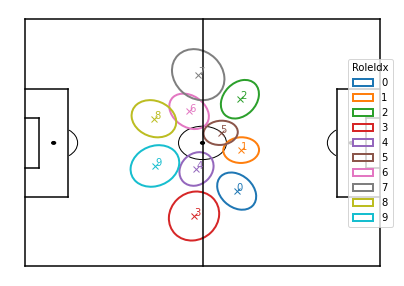

In [13]:
# Draw ROLE distributions
playerMus_role = np.mean(tracks_role, axis=0)

fig,ax = plt.subplots(figsize=(7,5))
draw_pitch(ax, width=1, height=1)
plt.axis('off')

for playerIdx in range(tracks_A1_meanNorm.shape[1]):
    confidence_ellipse(tracks_role[:,playerIdx,0]+0.5, tracks_role[:,playerIdx,1]+0.5, ax, n_std=1.0, edgecolor=my_colors[playerIdx], lw=2.0, label=playerIdx)   

    ax.plot(playerMus_role[playerIdx, 0]+0.5, playerMus_role[playerIdx, 1]+0.5, c=my_colors[playerIdx], marker='x')
    ax.annotate(playerIdx, (playerMus_role[playerIdx, 0]+0.5, playerMus_role[playerIdx, 1]+0.5), c=my_colors[playerIdx]) # text labels
    
    
ax.legend(loc='center right', title="RoleIdx");